# Workflow Examples


`xclim` is built on very powerful multiprocessing and distributed computation libraries, notably `xarray` and `dask`.

`xarray` is a python package making it easy to work with n-dimensional arrays. It labels axes with their names `[time, lat, lon, level]` instead of indices `[0,1,2,3]`, reducing the likelihood of bugs and making the code easier to understand. One of the key strengths of `xarray` is that it knows how to deal with non-standard calendars (we're looking at you, "`360_days`") and can easily resample daily time series to weekly, monthly, seasonal or annual periods.  Finally, `xarray` is tightly integrated with `dask`, a package that can automatically parallelize operations.

The following are a few examples to consult when using `xclim` to subset NetCDF arrays and compute climate indicators, taking advantage of the parallel processing capabilities offered by `xarray` and `dask`. For more information about these projects, please see their documentation pages:

* [xarray documentation](https://xarray.pydata.org/en/stable/)
* [dask documentation](https://docs.dask.org/en/stable/)

## Environment configuration

In [1]:
import tempfile
from pathlib import Path

import xarray as xr

import xclim.indices

# Set xarray to use HTML for displaying outputs
xr.set_options(display_style="html")

# Output folder
output_folder = Path(tempfile.mkdtemp())

## Setting up the Dask client: parallel processing


<div class="alert alert-info">

In this example, we are using the ``**dask.distributed**`` submodule. This is not installed by default in a basic `xclim` installation. Be sure to add `distributed` to your Python installation before setting up parallel processing operations!

</div>

First, we create a pool of workers that will wait for jobs. The `xarray` library will automatically connect to these workers and dispatch them jobs that can be run in parallel.

The dashboard link lets you see in real time how busy those workers are.

* [dask distributed documentation](https://distributed.dask.org/en/latest/)

This step is not mandatory, as `dask` will fall back to its "single machine scheduler" if a `Client` is not created. However, this default scheduler doesn't allow you to set the number of threads or a memory limit and doesn't start the dashboard, which can be quite useful to understand your task's progress.


In [2]:
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client = Client(n_workers=1, threads_per_worker=4, memory_limit="4GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60749,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:60756,Total threads: 4
Dashboard: http://127.0.0.1:60757/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:60752,


## Creating xarray datasets

To open a NetCDF file with `xarray`, we use `xr.open_dataset(<path to file>)`. By default, the entire file is stored in one chunk, so there is no parallelism. To trigger parallel computations, we need to explicitly specify the **chunk size**.

<div class="alert alert-info">

In this example, instead of opening a local file, we pass an *OPeNDAP* URL to xarray. It retrieves the data automatically. Notice also that opening the dataset is quite fast. In fact, the data itself has not been downloaded yet, only the coordinates and the metadata. The downloads will be triggered only when the values need to be accessed directly.

</div>

`dask`'s parallelism is based on memory chunks; We need to tell `xarray` to split our NetCDF array into chunks of a given size, and operations on each chunk of the array will automatically be dispatched to the workers.

In [3]:
data_url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/bias_adjusted/cmip6/ouranos/ESPO-G/ESPO-G6-E5Lv1.0.0/day_ESPO-G6-E5L_v1.0.0_CMIP6_ScenarioMIP_NAM_CSIRO_ACCESS-ESM1-5_ssp370_r1i1p1f1_1950-2100.ncml"

In [4]:
# Chunking in memory along the time dimension.
# Note that the data type is a 'dask.array'. xarray will automatically use client workers.
ds = xr.open_dataset(
    data_url,
    chunks={"time": 1460, "lat": 50, "lon": 50},
    engine="netcdf4",
)
ds

<xarray.Dataset> Size: 825GB
Dimensions:  (lat: 734, lon: 1700, time: 55115)
Coordinates:
  * lat      (lat) float32 3kB 10.0 10.1 10.2 10.3 10.4 ... 83.0 83.1 83.2 83.3
  * lon      (lon) float32 7kB -179.9 -179.8 -179.7 -179.6 ... -10.2 -10.1 -10.0
  * time     (time) object 441kB 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    tasmin   (time, lat, lon) float32 275GB dask.array<chunksize=(1460, 50, 50), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 275GB dask.array<chunksize=(1460, 50, 50), meta=np.ndarray>
    pr       (time, lat, lon) float32 275GB dask.array<chunksize=(1460, 50, 50), meta=np.ndarray>
Attributes: (12/84)
    Conventions:                     CF-1.7 CMIP-6.2
    Notes:                           Regridded on the grid of ERA5-Land, then...
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           21915.0
    ...                              ...
    bias_adjust_reference_citation:  https://doi.org/10.24381/cds.e2161bac
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              CSIRO

In [5]:
print(ds.tasmin.chunks)

((1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1095), (50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 34), (50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50))


## Multi-file datasets

NetCDF files are often split into periods to keep file size manageable. A single dataset can be split in dozens of individual files. `xarray` has a function `open_mfdataset` that can open and aggregate a list of files and construct a unique *logical* dataset. `open_mfdataset` can aggregate files over coordinates (time, lat, lon) and variables.

* Note that opening a multi-file dataset automatically chunks the array (one chunk per file).
* Note also that because `xarray` reads every file metadata to place it in a logical order, it can take a while to load.

In [6]:
# Create multi-file data & chunks
# ds = xr.open_mfdataset('/path/to/files*.nc')

## Subsetting and selecting data with xarray
Here, we will reduce the size of our data using the methods implemented in xarray ([docs here](https://docs.xarray.dev/en/stable/user-guide/indexing.html)).

In [7]:
ds2 = ds.sel(lat=slice(50, 45), lon=slice(-70, -65), time=slice("2090", "2100"))
ds2.tasmin

<xarray.DataArray 'tasmin' (time: 4015, lat: 0, lon: 51)> Size: 0B
dask.array<getitem, shape=(4015, 0, 51), dtype=float32, chunksize=(1460, 0, 50), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 0B 
  * lon      (lon) float32 204B -70.0 -69.9 -69.8 -69.7 ... -65.2 -65.1 -65.0
  * time     (time) object 32kB 2090-01-01 00:00:00 ... 2100-12-31 00:00:00
Attributes:
    long_name:                                   Minimal daily temperature
    cell_methods:                                time: minimum within days
    description:                                 Daily minimal temperature as...
    history:                                     [2024-11-08 04:09:23] Data c...
    standard_name:                               air_temperature
    units:                                       K
    _QuantizeBitRoundNumberOfSignificantDigits:  12
    _ChunkSizes:                                 [1460   50   50]

In [8]:
ds3 = ds.sel(lat=46.8, lon=-71.22, method="nearest").sel(time="1993")
ds3.tasmin

<xarray.DataArray 'tasmin' (time: 365)> Size: 1kB
dask.array<getitem, shape=(365,), dtype=float32, chunksize=(365,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 4B 46.8
    lon      float32 4B -71.2
  * time     (time) object 3kB 1993-01-01 00:00:00 ... 1993-12-31 00:00:00
Attributes:
    long_name:                                   Minimal daily temperature
    cell_methods:                                time: minimum within days
    description:                                 Daily minimal temperature as...
    history:                                     [2024-11-08 04:09:23] Data c...
    standard_name:                               air_temperature
    units:                                       K
    _QuantizeBitRoundNumberOfSignificantDigits:  12
    _ChunkSizes:                                 [1460   50   50]

For more powerful subsetting tools with features such as coordinate reference system (CRS) aware subsetting and vector shape masking, the `xclim` developers strongly encourage users to consider the subsetting utilities of the [clisops](https://github.com/roocs/clisops) package.

Their documentation showcases several examples of how to perform more complex subsetting: [clisops.core.subset](https://clisops.readthedocs.io/en/latest/notebooks/core_subset.html).

## Climate index calculation & resampling frequencies

`xclim` has two layers for the calculation of indicators. The bottom layer is composed of a list of functions that take one or more `xarray.DataArray`'s as input and return an `xarray.DataArray` as output. You'll find these functions in `xclim.indices`. The indicator's logic is contained in this function, as well as some unit handling, but it doesn't perform any data consistency checks (like if the time frequency is daily), and doesn't adjust the metadata of the output array.

The second layer are class instances that you'll find organized by *realm*. So far, there are three realms available in `xclim.atmos`, `xclim.seaIce` and `xclim.land`, the first one being the most exhaustive. Before running computations, these classes check if the input data is a daily average of the expected variable:

1. If an indicator expects a daily mean, and you pass it a daily max, a `warning` will be raised.
2. After the computation, it also checks the number of values per period to make sure there are not missing values or `NaN` in the input data. If there are, the output is going to be set to `NaN`.  Ex. : If the indicator performs a yearly resampling, but there are only 350 non-`NaN` values in one given year in the input data, that year's output will be `NaN`.
3. The output units are set correctly as well as other properties of the output array, complying as much as possible with CF conventions.

For new users, we suggest you use the classes found in `xclim.atmos` and others. If you know what you're doing, and you want to circumvent the built-in checks, then you can use the `xclim.indices` directly.

Almost all `xclim` indicators convert daily data to lower time frequencies, such as seasonal or annual values. This is done using `xarray.DataArray.resample` method. Resampling creates a grouped object over which you apply a reduction operation (e.g. mean, min, max). The list of available frequency is given in the link below, but the most often used are:

- `YS`: annual starting in January
- `YS-JUL`: annual starting in July
- `MS`: monthly
- `QS-DEC`: seasonal starting in December

More info about this specification can be found in [pandas' documentation](http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)

Note - not all offsets in the link are supported by ``cftime`` objects in `xarray`.


In the example below, we're computing the **annual maximum temperature of the daily maximum temperature (tx_max)**.

In [9]:
out = xclim.atmos.tx_max(ds2.tasmax, freq="YS")
out

ValueError: zero-size array to reduction operation fmax which has no identity

<div class="alert alert-info">

If you execute the cell above, you'll see that this operation is quite fast. This a feature coming from dask. Read *Lazy computation*  further down.

</div>

### Comparison of **atmos** vs **indices** modules
Using the `xclim.indices` module performs not checks and only fills the `units` attribute.

In [10]:
out = xclim.indices.tx_days_above(ds2.tasmax, thresh="30 degC", freq="YS")
out

<xarray.DataArray 'tasmax' (time: 11, lat: 0, lon: 51)> Size: 0B
dask.array<mul, shape=(11, 0, 51), dtype=int64, chunksize=(1, 0, 50), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 0B 
  * lon      (lon) float32 204B -70.0 -69.9 -69.8 -69.7 ... -65.2 -65.1 -65.0
  * time     (time) object 88B 2090-01-01 00:00:00 ... 2100-01-01 00:00:00
Attributes:
    units:    d

With `xclim.atmos`, checks are performed and many CF-compliant attributes are added:

In [11]:
out = xclim.atmos.tx_days_above(ds2.tasmax, thresh="30 degC", freq="YS")
out

<xarray.DataArray 'tx_days_above' (time: 11, lat: 0, lon: 51)> Size: 0B
dask.array<where, shape=(11, 0, 51), dtype=float64, chunksize=(1, 0, 50), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 0B 
  * lon      (lon) float32 204B -70.0 -69.9 -69.8 -69.7 ... -65.2 -65.1 -65.0
  * time     (time) object 88B 2090-01-01 00:00:00 ... 2100-01-01 00:00:00
Attributes:
    units:          days
    cell_methods:   time: maximum within days time: sum over days
    history:        [2025-11-04 10:43:18] tx_days_above: TX_DAYS_ABOVE(tasmax...
    standard_name:  number_of_days_with_air_temperature_above_threshold
    long_name:      The number of days with maximum temperature above 30 degc
    description:    Annual number of days where daily maximum temperature exc...

In [12]:
# We have created an xarray data-array.
# We can insert this into an output xr.Dataset object with a copy of the original dataset global attrs
ds_out = xr.Dataset(attrs=ds2.attrs)

# Add our climate index as a data variable to the dataset
ds_out[out.name] = out
ds_out

<xarray.Dataset> Size: 292B
Dimensions:        (lat: 0, lon: 51, time: 11)
Coordinates:
  * lat            (lat) float32 0B 
  * lon            (lon) float32 204B -70.0 -69.9 -69.8 ... -65.2 -65.1 -65.0
  * time           (time) object 88B 2090-01-01 00:00:00 ... 2100-01-01 00:00:00
Data variables:
    tx_days_above  (time, lat, lon) float64 0B dask.array<chunksize=(1, 0, 1), meta=np.ndarray>
Attributes: (12/84)
    Conventions:                     CF-1.7 CMIP-6.2
    Notes:                           Regridded on the grid of ERA5-Land, then...
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           21915.0
    ...                              ...
    bias_adjust_reference_citation:  https://doi.org/10.24381/cds.e2161bac
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              CSIRO

### Different ways of resampling

Many indices use algorithms that find the length of given sequences. For instance, `xclim.indices.heat_wave_max_length` finds the longest sequence where `tasmax` and `tasmin` are above given threshold values. Resampling can be used to find the longest sequence in given periods of time, for instance the longest heat wave for each month if the resampling frequency is `freq == "MS"`.

The order of the two operations just described, i.e. :
* Finding the length of sequences respecting a certain criterion ("run length algorithms")
* Separating the dataset in given time periods ("resampling")

is important and can lead to differing results.

The cell below illustrates this by looking at the maximum lengths of heat waves each month from May 2010 to August 2010 by doing these operations in the two possible orders. The heat wave max lengths for July in a small region of interest $\text{lat} \in [43, 44.5],\, \text{lon} \in [-117.5, -116]$ are shown: The maximal lengths are sometimes longer first applying the run length algorithm (`resample_before_rl == False`).


In [13]:
# import plotting stuff
import matplotlib.pyplot as plt

%matplotlib inline


plt.rcParams["figure.figsize"] = (11, 5)

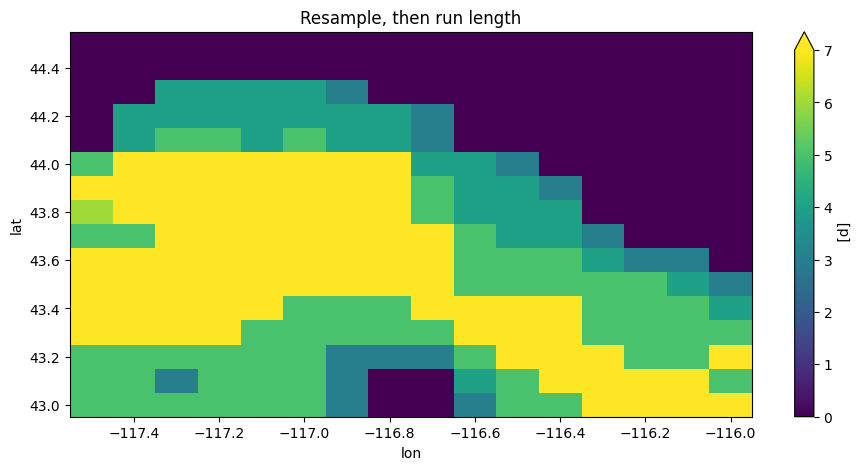

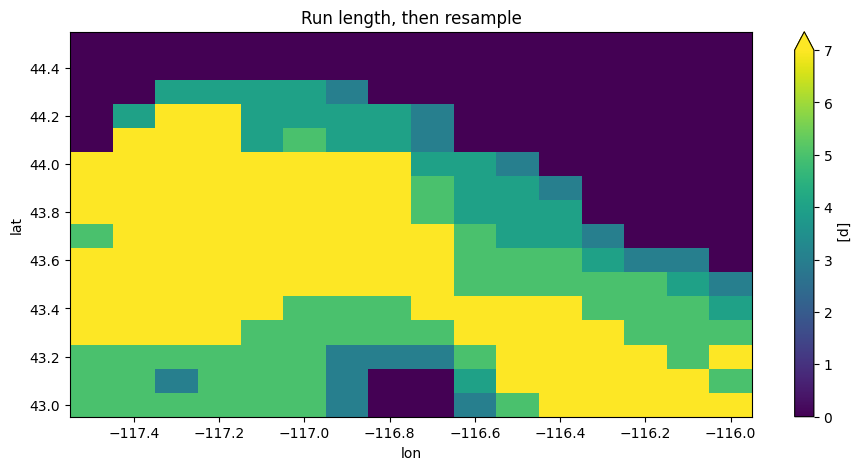

In [14]:
ds_reduced = ds.sel(lat=slice(43, 44.5)).sel(lon=slice(-117.5, -116)).sel(time=slice("2010-05-01", "2011-08-31"))
tn, tx = ds_reduced.tasmin, ds_reduced.tasmax
freq = "MS"

# Threshold on tasmin: chosen smaller than the default 22.0 degC
thresh_tn = "20.0 degC"

# Computing index by resampling **before** run length algorithm (default value)
hw_before = xclim.indices.heat_wave_max_length(tn, tx, freq=freq, thresh_tasmin=thresh_tn, resample_before_rl=True)
# Computing index by resampling **after** run length algorithm
hw_after = xclim.indices.heat_wave_max_length(tn, tx, freq=freq, thresh_tasmin=thresh_tn, resample_before_rl=False)

hw_before.sel(time="2010-07-01").plot(vmin=0, vmax=7)
plt.title("Resample, then run length")
plt.figure()
hw_after.sel(time="2010-07-01").plot(vmin=0, vmax=7)
plt.title("Run length, then resample")
plt.show()

Let's focus on the point $(-117.2, 44.2)$, which has a maximum wave length of five (5) or seven (7), depending on whether resampling occurs _before_ or _after_ the run length algorithm.

Plotting the values of `tasmin` in July and early August, we see a sequence of seven hot minimal temperatures at the end of July that surpass the threshold to qualify for a heat wave.

1. If resampling occurs first, and we first separate the periods in months, the run length algorithms will only look for sequences of hot days **within** the month of July and will exclude the last three days of this sequence of seven days.

2. Using the run length algorithm before resampling looks for sequences of hot days in all the dataset given (temperatures from May 1, 2010, to August 31, 2010), and then subdivides these sequences in the months when they have started. Since it starts in July, this sequence is registered as counts for a heat wave of seven days happening in July.

This also implies that the first three days of August which belong in this sequence of seven days will be counted as a sequence in August with the first method, but not with the second.

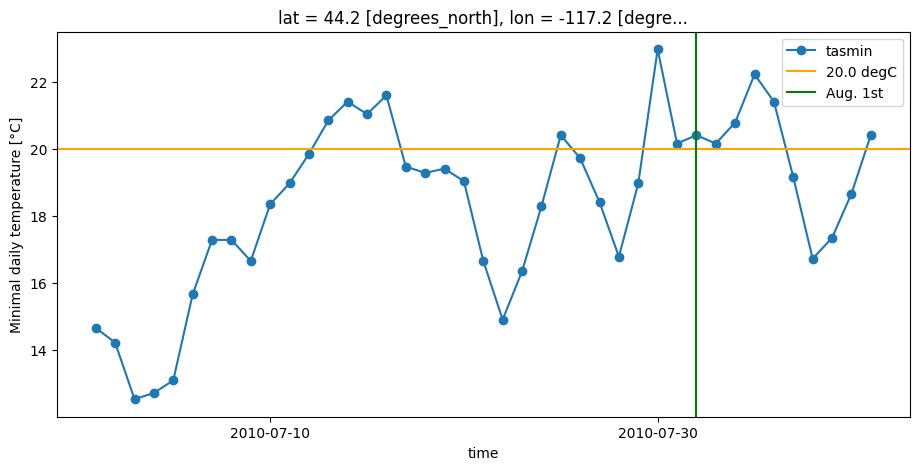

In [15]:
import cftime

from xclim.core.units import convert_units_to

# Select a spatial point of interest in July-early August
lon_i, lat_i = -117.2, 44.2
tn_pt = tn.sel(time=slice("2010-07-01", "2010-08-10")).sel(lat=lat_i, lon=lon_i, method="nearest")
tn_pt = convert_units_to(tn_pt, "degC")

# Find August 1st threshold value
aug1 = cftime.datetime(2010, 8, 1, calendar="noleap")

tn_pt.plot(marker="o", label="tasmin")
plt.axhline(y=convert_units_to(thresh_tn, "degC"), color="orange", label=thresh_tn)
plt.axvline(x=aug1, color="green", label="Aug. 1st")
plt.legend()
plt.show()

## *Lazy* computation - Nothing has been computed so far !

If you look at the output of those operations, they're identified as `dask.array` objects. What happens is that `dask` creates a chain of operations that, when executed, will yield the values we want. We have thus far only created a schedule of tasks with a small preview and not done any actual computations, except when making figures. You can trigger computations by using the `load` or `compute` method, or writing the output to disk via `to_netcdf`. Of course, calling `.plot()` will also trigger the computation.

In [16]:
%%time
output_file = output_folder / "test_tx_max.nc"
ds_out.to_netcdf(output_file)

CPU times: total: 156 ms
Wall time: 1.2 s


*(Times may of course vary depending on the machine and the Client settings)*

### Performance tips
#### Optimizing the chunk size

You can improve performance by being smart about chunk sizes. If chunks are too small, there is a lot of time lost in overhead. If chunks are too large, you may end up exceeding the individual worker memory limit.

In [17]:
print(ds2.chunks["time"])

(1460, 1460, 1095)


In [18]:
# rechunk data in memory for the entire grid
ds2c = ds2.chunk(chunks={"time": 4 * 365})
print(ds2c.chunks["time"])

(1460, 1460, 1095)


In [19]:
%%time
out = xclim.atmos.tx_max(ds2c.tasmax, freq="YS")
ds_out = xr.Dataset(data_vars=None, coords=out.coords, attrs=ds.attrs)
ds_out[out.name] = out

output_file = output_folder / "test_tx_max.nc"
ds_out.to_netcdf(output_file)

ValueError: zero-size array to reduction operation fmax which has no identity

#### Loading the data in memory
If the dataset is relatively small, it might be more efficient to simply load the data into the memory and use  numpy arrays instead of dask arrays.

In [20]:
ds4 = ds3.load()

## Unit handling in `xclim`

A lot of effort has been placed into automatic handling of input data units. `xclim` will automatically detect the input variable(s) units (e.g. `°C` versus `°K` or `mm/s` versus `mm/day` etc.) and adjust on-the-fly in order to calculate indices in the consistent manner. This comes with the obvious caveat that input data requires metadata attribute for units.

The [Units Handling](units.ipynb) page goes more into detail on how unit conversion can easily be done.

In the example below, we compute weekly total precipitation in mm using inputs of `mm/s` and `mm/d`. As we can see, the output is identical.

In [21]:
# Compute with the original mm s-1 data
out1 = xclim.atmos.precip_accumulation(ds4.pr, freq="MS")
# Create a copy of the data converted to mm d-1
pr_mmd = ds4.pr * 3600 * 24
pr_mmd.attrs["units"] = "mm d-1"
out2 = xclim.atmos.precip_accumulation(pr_mmd, freq="MS")

C:\Users\llierham\mobaxterm\github_ll\xclim\src\xclim\core\cfchecks.py:77: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(getattr(vardata, "cell_methods", None), data["cell_methods"])
C:\Users\llierham\mobaxterm\github_ll\xclim\src\xclim\core\cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


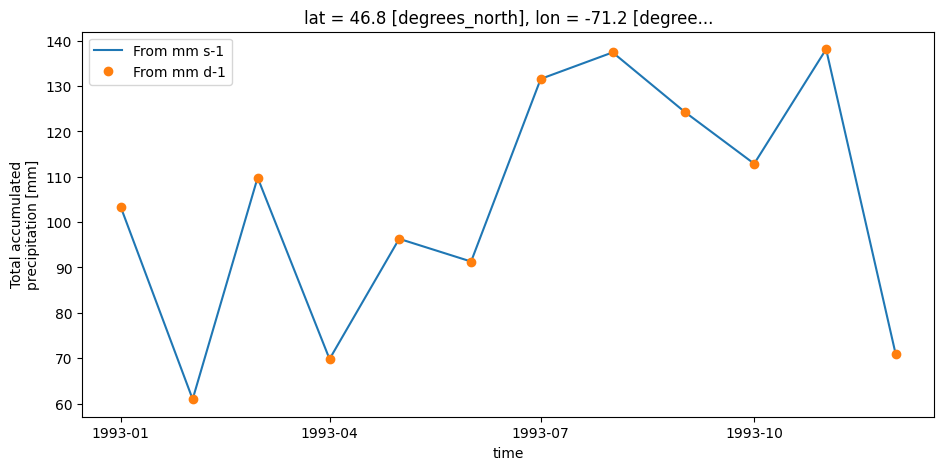

In [22]:
plt.figure()
out1.plot(label="From mm s-1", linestyle="-")
out2.plot(label="From mm d-1", linestyle="none", marker="o")
plt.legend()
plt.show()

### Threshold indices

`xclim` unit handling also applies to threshold indicators. Users can provide threshold in units of choice and `xclim` will adjust automatically. For example, determining the number of days with tasmax > 20 °C, users can define a threshold input of ``"20 C"`` or ``"20 degC"`` even if input data is in Kelvin. Alternatively, users can even provide a threshold in Kelvin (``"293.15 K"``, if they really wanted to).

C:\Users\llierham\mobaxterm\github_ll\xclim\src\xclim\core\cfchecks.py:77: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(getattr(vardata, "cell_methods", None), data["cell_methods"])
C:\Users\llierham\mobaxterm\github_ll\xclim\src\xclim\core\cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])
C:\Users\llierham\mobaxterm\github_ll\xclim\src\xclim\core\cfchecks.py:77: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(getattr(vardata, "cell_methods", None), data["cell_methods"])
C:\Users\llierham\mobaxterm\github_ll\xclim\src\xclim\core\cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


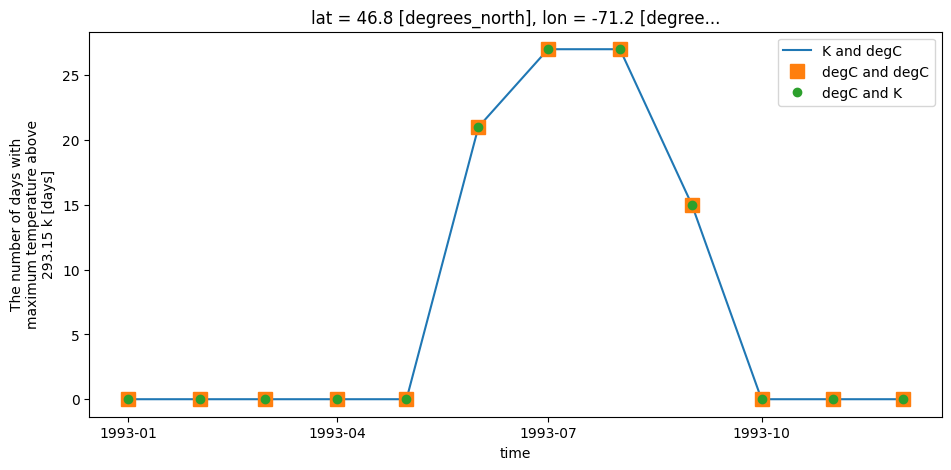

In [23]:
# Create a copy of the data converted to C
tasmax_C = ds4.tasmax - 273.15
tasmax_C.attrs["units"] = "C"

# Using Kelvin data, threshold in Celsius
out1 = xclim.atmos.tx_days_above(ds4.tasmax, thresh="20 C", freq="MS")

# Using Celsius data
out2 = xclim.atmos.tx_days_above(tasmax_C, thresh="20 C", freq="MS")

# Using Celsius but with threshold in Kelvin
out3 = xclim.atmos.tx_days_above(tasmax_C, thresh="293.15 K", freq="MS")

# Plot and see that it's all identical:
plt.figure()
out1.plot(label="K and degC", linestyle="-")
out2.plot(label="degC and degC", marker="s", markersize=10, linestyle="none")
out3.plot(label="degC and K", marker="o", linestyle="none")
plt.legend()
plt.show()

#### Spatially varying thresholds
Thresholds can also be passed as DataArrays instead of single scalar values, allowing the computation to depend on one or more non-temporal dimensions. The `units` attribute must be set.

Going back to the initial `ds`, we'll subset it and compute the length of the heat wave according to thresholds that vary along the latitude and longitude.

In [24]:
ds5 = ds.sel(time=slice("1950", "1960"), lat=slice(46, 50), lon=slice(-75, -71))
ds5

<xarray.Dataset> Size: 81MB
Dimensions:  (lat: 41, lon: 41, time: 4015)
Coordinates:
  * lat      (lat) float32 164B 46.0 46.1 46.2 46.3 46.4 ... 49.7 49.8 49.9 50.0
  * lon      (lon) float32 164B -75.0 -74.9 -74.8 -74.7 ... -71.2 -71.1 -71.0
  * time     (time) object 32kB 1950-01-01 00:00:00 ... 1960-12-31 00:00:00
Data variables:
    tasmin   (time, lat, lon) float32 27MB dask.array<chunksize=(1460, 40, 1), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 27MB dask.array<chunksize=(1460, 40, 1), meta=np.ndarray>
    pr       (time, lat, lon) float32 27MB dask.array<chunksize=(1460, 40, 1), meta=np.ndarray>
Attributes: (12/84)
    Conventions:                     CF-1.7 CMIP-6.2
    Notes:                           Regridded on the grid of ERA5-Land, then...
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           21915.0
    ...                              ...
    bias_adjust_reference_citation:  https://doi.org/10.24381/cds.e2161bac
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              CSIRO

In [25]:
# The tasmin threshold is 7°C for the northern half of the domain and 11°C for the southern half.
# (notice that the lat coordinate is in decreasing order : from north to south)
thresh_tasmin = xr.DataArray([7] * 20 + [11] * 21, dims=("lat",), coords={"lat": ds5.lat}, attrs={"units": "°C"})
# The tasmax threshold is 17°C for the western half of the domain and 21°C for the eastern half.
thresh_tasmax = xr.DataArray([17] * 20 + [21] * 21, dims=("lon",), coords={"lon": ds5.lon}, attrs={"units": "°C"})

out_hw2d = xclim.atmos.heat_wave_total_length(
    tasmin=ds5.tasmin,
    tasmax=ds5.tasmax,
    thresh_tasmin=thresh_tasmin,
    thresh_tasmax=thresh_tasmax,
    freq="YS",
    window=3,
)

The final map for year 1958, shows clear jumps across the 4 quadrants, which was expected with our space-dependent thresholds. Notice also how the `long_name` (printed on the colorbar label) mentions that the threshold comes from "an array". This imprecise metadata is a consequence of using `DataArray`-derived thresholds.

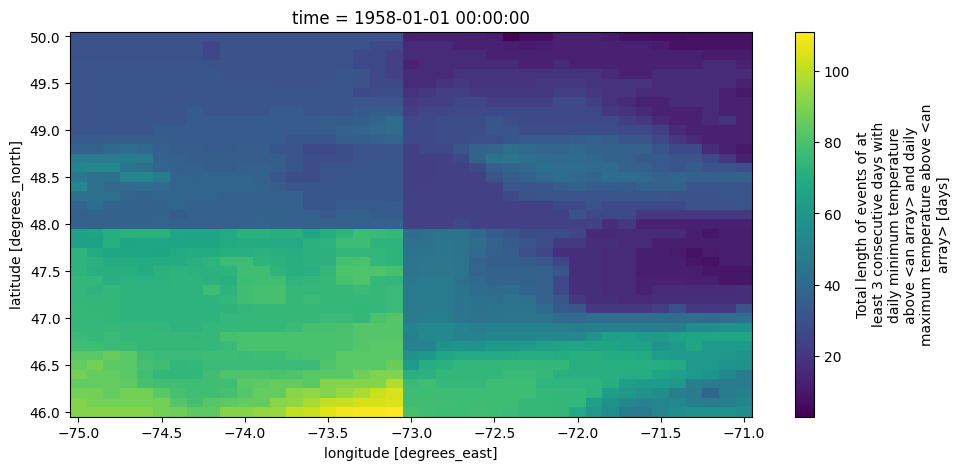

In [26]:
out_hw2d.sel(time="1958").plot()
plt.show()

#### Hemisphere varying thresholds

Some indicators should be computed with different parameters for the north and the south hemisphere. We want to compute the number of frost days during the winter months. In the nothern hemisphere we set the end of a full winter year to July, in the southern hemisphere to December.

In [27]:
freq_nh = "YS-JUL"
freq_sh = "YS"

Going back to the initial `ds`, we'll select the northern and southern hemispheres and compute the number of frost days during the winter month separately.

In [28]:
ds6 = ds.sel(time=slice("1950", "1951"))
ds6

<xarray.Dataset> Size: 11GB
Dimensions:  (lat: 734, lon: 1700, time: 730)
Coordinates:
  * lat      (lat) float32 3kB 10.0 10.1 10.2 10.3 10.4 ... 83.0 83.1 83.2 83.3
  * lon      (lon) float32 7kB -179.9 -179.8 -179.7 -179.6 ... -10.2 -10.1 -10.0
  * time     (time) object 6kB 1950-01-01 00:00:00 ... 1951-12-31 00:00:00
Data variables:
    tasmin   (time, lat, lon) float32 4GB dask.array<chunksize=(730, 50, 50), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 4GB dask.array<chunksize=(730, 50, 50), meta=np.ndarray>
    pr       (time, lat, lon) float32 4GB dask.array<chunksize=(730, 50, 50), meta=np.ndarray>
Attributes: (12/84)
    Conventions:                     CF-1.7 CMIP-6.2
    Notes:                           Regridded on the grid of ERA5-Land, then...
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           21915.0
    ...                              ...
    bias_adjust_reference_citation:  https://doi.org/10.24381/cds.e2161bac
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              CSIRO

In [29]:
tasmin_nh = ds6.tasmin.sel(lat=slice(0, 90))
tasmin_sh = ds6.tasmin.sel(lat=slice(-90, 0))

In [30]:
frost_days_nh = xclim.atmos.frost_days(tasmin_nh, freq=freq_nh)
frost_days_sh = xclim.atmos.frost_days(tasmin_sh, freq=freq_sh)

> **Note:** We have a handle both hemispheres separately since we get different time axes for each hemisphere.

In [31]:
frost_days_nh.time

<xarray.DataArray 'time' (time: 3)> Size: 24B
array([cftime.DatetimeNoLeap(1949, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1951, 7, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 24B 1949-07-01 00:00:00 ... 1951-07-01 00:00:00

In [32]:
frost_days_sh.time

<xarray.DataArray 'time' (time: 2)> Size: 16B
array([cftime.DatetimeNoLeap(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1951, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 16B 1950-01-01 00:00:00 1951-01-01 00:00:00